## Sandbox for Implementing RetinaNet

Practice training runs on complex deep networks and experiment with object detection and segmentation pipelines. Includes implementation of U-Net as basis for studying skip connections, Feature Pyramid Networks, and RetinaNet. 

## General Approach

1. Download CamVid
- Build and train U-Net
- Download COCO
- Build and train RetinaNet

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *

## Glioblastoma-Astrocytoma and HeLa Cells

In [85]:
def get_img_lbls(path, seq):
    lbl = [l.name[-7:-4] for l in (path/f'0{seq}_GT'/'SEG').ls()]
    img = [i.name for i in (path/f'0{seq}').ls() if i.name[-7:-4] in lbl]
    return img

def get_data(path, sz=512, bs=1):
    ifiles = get_img_lbls(path, 1) + get_img_lbls(path, 2)
    get_y_fn = lambda path, o: path/f'0{o.stem[0]}_GT'/'SEG'/f'{o.stem[0]}man_seg{o.stem[-3:]}{o.suffix}'
    return (SegmentationItemList.from_folder(path)
            .filter_by_folder(include=['01', '02'])
            .filter_by_func(lambda fname: fname.name in ifiles)
            .split_by_rand_pct(0.1)
            .label_from_func(partial(get_y_fn, path), classes=['background', 'foreground'])
            .transform(get_transforms(flip_vert=True, max_warp=0.5), tfm_y=True, size=sz)
            .databunch(bs=bs))

In [86]:
glioma_path = Path('/home/sudosharma/projects/data/glioma')
hela_path = Path('/home/sudosharma/projects/data/hela')

In [87]:
glioma, hela = get_data(glioma_path, sz=520), get_data(hela_path, sz=512)

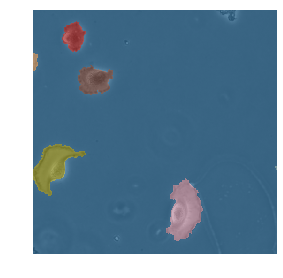

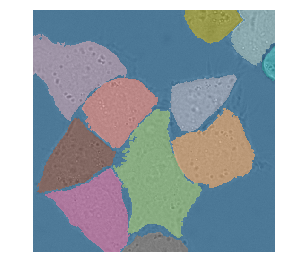

In [88]:
glioma.show_batch(); hela.show_batch()

## U-Net

In [6]:
class SaveMaps():
    """Save feature maps from contraction phase of unet after second convolution."""
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): self.map = output
    def remove(self): self.hook.remove()

        
@dataclass
class SqueezeTarget(LearnerCallback):
    """Callback for adjusting target tensor shape for calculating cross entropy."""
    learn: Learner
    def on_batch_begin(self, **kwargs): 
        return {'last_target': kwargs['last_target'].squeeze(1)}
    
    
def iou(input, targs, classes):
    """Custom intersection-over-union metric for multi-class segmentation."""
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n, -1)
    targs = targs.contiguous().view(n, -1)
    inp = torch.stack([input==i for i in range(classes)]).cuda()
    tar = torch.stack([targs==i for i in range(classes)]).cuda()
    intersect = lambda a, b: (a*b).sum().float()
    union = lambda a, b: (a+b).sum().float()
    i = torch.stack([intersect(a, b) for a, b in zip(inp, tar)]).sum().float()
    u = torch.stack([union(a, b) for a, b in zip(inp, tar)]).sum().float()
    return i/u

In [7]:
def conv(ic, oc, k=3, s=1, p=0, actn=True):
    """Conv and optional activation."""
    layers = [nn.Conv2d(ic, oc, k, stride=s, padding=p)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers).cuda()


def conv_block(ic, oc, transpose=False, maxpool=True): 
    """Two conv block with optional conv transpose and maxpool modules."""
    layers = [conv(ic, oc, p=1), conv(oc, oc, p=1)]
    if transpose: layers.append(nn.ConvTranspose2d(oc, oc//2, 2, stride=2))
    if maxpool: layers.append(nn.MaxPool2d(2, stride=2))
    return nn.Sequential(*layers).cuda()


def unet_down(cs): 
    """Downward contraction pathway of UNet."""
    layers = [conv_block(cs[i], cs[i+1]) for i in range(len(cs)-2)]
    layers.append(conv_block(cs[-2], cs[-1], transpose=True, maxpool=False))
    return nn.Sequential(*layers).cuda()


def unet_up(cs):
    """Upward expansion pathway of UNet."""
    cs.reverse()
    cs.pop()
    layers = [conv_block(cs[i], cs[i+1], transpose=True, maxpool=False) for i in range(len(cs)-2)]
    layers.append(conv_block(cs[-2], cs[-1], transpose=False, maxpool=False))
    return nn.ModuleList(layers)


class UNet(nn.Module):
    """UNet module with down path, up path, and cross connections using saved feature maps."""
    def __init__(self, channels, classes):
        super().__init__()
        self.unet_down = unet_down(channels)
        self.unet_up = unet_up(channels)
        self.drop_conv = nn.Sequential(conv(channels[-1], classes, k=1, actn=False), nn.Dropout(0., True))
        self.maps = [SaveMaps(block[-2]) for block in children(self.unet_down)]
        self.maps.pop()
        self.maps.reverse()
        
    def forward(self, x): 
        """Concatenate features maps from corresponding convolution+relu outputs in up/down paths."""
        x = self.unet_down(x)
        for i, m in enumerate(self.unet_up):
            x = torch.cat([self.maps[i].map, x], dim=1)
            x = m(x)
        return self.drop_conv(x)
    
    def close(self): 
        for mp in self.maps: mp.remove()

## CamVid

In [3]:
path = untar_data(URLs.CAMVID)
path_lbl = path/'labels'
path_img = path/'images'
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [4]:
def get_data(sz=256, bs=32, path_img=path_img, path_lbl=path_lbl, codes=codes):
    """Create data loader with different batch sizes and size of image."""
    get_y_fn = lambda o: path_lbl/f'{o.stem}_P{o.suffix}'
    return (SegmentationItemList.from_folder(path_img)
            .split_by_rand_pct()
            .label_from_func(get_y_fn, classes=codes)
            .transform(get_transforms(), tfm_y=True, size=sz)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

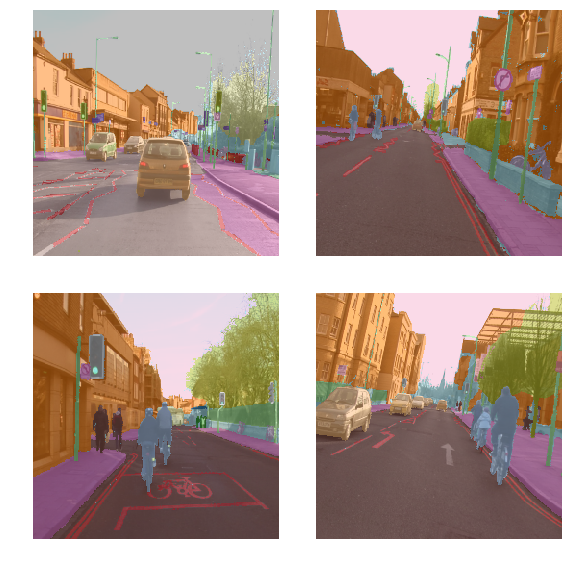

In [5]:
data = get_data()
data.show_batch(2)

In [8]:
channels = [3, 64, 128, 256, 512, 1024]
classes = len(data.classes)
model = UNet(channels, classes)

In [9]:
learn = Learner(data, 
                model, 
                metrics=[partial(iou, classes=classes)], 
                opt_func=partial(torch.optim.SGD, momentum=0.99),
                loss_func=F.cross_entropy,
                callback_fns=[SqueezeTarget])
learn.init(nn.init.kaiming_normal_)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


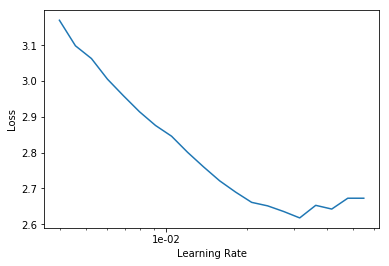

In [10]:
with gpu_mem_restore_ctx():  # prevent having to restart kernel for CUDA errors
    learn.lr_find(start_lr=1e-3, end_lr=1e3)
    learn.recorder.plot()

In [11]:
callbacks = [
    SaveModelCallback(learn, monitor='iou', mode='max', name='unet'), 
    TerminateOnNaNCallback(), 
    GradientClipping(learn, clip=0.1),
    ReduceLROnPlateauCallback(learn, patience=50, min_delta=0.001)]
learn.callbacks.extend(callbacks)

In [12]:
learn.fit(1500, 1e-2)

epoch,train_loss,valid_loss,iou,time
0,4.336361,3.227644,0.068481,00:20
1,3.432487,2.429641,0.227241,00:20
2,2.941198,2.370772,0.177433,00:20
3,2.684415,2.099101,0.245733,00:20
4,2.473808,2.029494,0.249913,00:20
5,2.306423,1.895032,0.260178,00:20
6,2.166724,1.759534,0.264124,00:20
7,2.035883,1.651581,0.288088,00:20
8,1.920136,1.568310,0.292792,00:20
9,1.820649,1.505368,0.298399,00:20


Better model found at epoch 0 with iou value: 0.06848139315843582.
Better model found at epoch 1 with iou value: 0.22724059224128723.
Better model found at epoch 3 with iou value: 0.24573282897472382.
Better model found at epoch 4 with iou value: 0.24991324543952942.
Better model found at epoch 5 with iou value: 0.26017773151397705.
Better model found at epoch 6 with iou value: 0.26412445306777954.
Better model found at epoch 7 with iou value: 0.2880876958370209.
Better model found at epoch 8 with iou value: 0.2927919030189514.
Better model found at epoch 9 with iou value: 0.2983987033367157.
Better model found at epoch 11 with iou value: 0.3030937612056732.
Better model found at epoch 12 with iou value: 0.3075300455093384.
Better model found at epoch 13 with iou value: 0.3107638359069824.
Better model found at epoch 15 with iou value: 0.3199651539325714.
Better model found at epoch 17 with iou value: 0.32507503032684326.
Better model found at epoch 18 with iou value: 0.325354397296905

Better model found at epoch 664 with iou value: 0.43312308192253113.
Better model found at epoch 670 with iou value: 0.4332160949707031.
Better model found at epoch 673 with iou value: 0.43342095613479614.
Better model found at epoch 683 with iou value: 0.4335381090641022.
Better model found at epoch 684 with iou value: 0.4337403476238251.
Better model found at epoch 687 with iou value: 0.43377381563186646.
Better model found at epoch 694 with iou value: 0.4340408444404602.
Better model found at epoch 701 with iou value: 0.43404725193977356.
Better model found at epoch 704 with iou value: 0.4342855215072632.
Better model found at epoch 715 with iou value: 0.43433675169944763.
Better model found at epoch 716 with iou value: 0.43441593647003174.
Better model found at epoch 730 with iou value: 0.43446651101112366.
Better model found at epoch 748 with iou value: 0.4346378743648529.
Better model found at epoch 764 with iou value: 0.43471139669418335.
Better model found at epoch 766 with iou

Exception ignored in: <function _releaseLock at 0x7fe7320400d0>
Traceback (most recent call last):
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/sud

KeyboardInterrupt: 

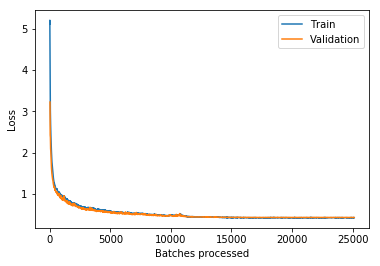

In [109]:
learn.recorder.plot_losses()

In [10]:
learn.load('unet')

/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (561 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/sudosharma/projects/data/camvid/images;

Valid: LabelList (140 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/sudosharma/projects/data/camvid/images;

Test: None, model=UNet(
  (unet_down): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
      )
      (1): Sequential(
       

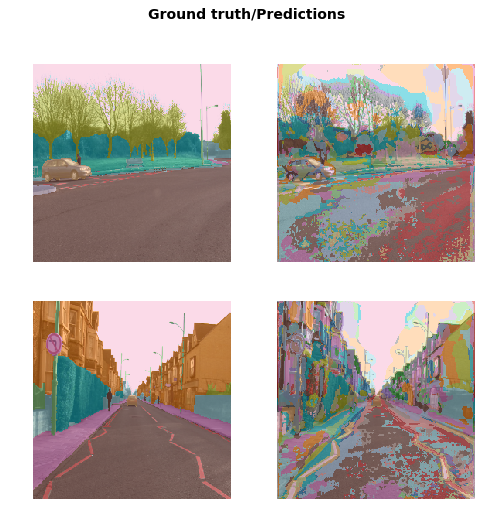

In [11]:
learn.show_results(rows=2)

In [15]:
learn.save('unet_acc_42')

In [21]:
model.close()

### U-Net Analysis on CamVid

I used the same optimizer as the origin paper, and the same general architecture. I added padding at the end of each convolution unlike in the paper, to preserve the output dimensions. This also make the upward path much easier to construct. Finally, I used similar data augmentation techniques and created a custom intersection-over-union metric for multi-class segmentation. 

<b>Why was not abe to get a higher IOU for this dataset?</b>
- Could have maybe trained for more epochs?
- Architecture not complex enough for CamVid?
- Maybe pretrained network on ImageNet would do much better. 
- Maybe there's not enough data
- In the U-Net paper they had a pre-computed weight map for each class to handle class imbalance, maybe if I added that the network would train faster/better. 

<b>Lessons:</b>
- pay close attention to shapes of tensors that pytorch's built-in loss functions expect
- modify tensor shapes using callbacks or forward hooks
- sometimes the loss landscape is really flat at the beginning, so you might have to train a while before seeing any improvement. 
- fastai doesn't recursively put every pytorch module on the GPU, might have to do it manually
- data augmentation can act as a form of regularization
- multi-class problems have a class-imbalance issue, where certain classes can be overrepresented. 

## COCO

In [83]:
path = Path('/home/sudosharma/projects/data/coco_tiny')
images, lbl_bbox = get_annotations(path/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

In [84]:
img2bbox

{'000000542959.jpg': [[[86.34, 32.52, 95.75, 41.050000000000004],
   [110.52, 98.12, 114.59, 100.07000000000001],
   [51.62, 91.28, 57.339999999999996, 95.23],
   [110.82, 110.48, 126.03999999999999, 125.03],
   [50.18, 96.63, 63.64, 115.3],
   [111.73, 0.69, 124.79, 12.49]],
  ['chair', 'vase', 'vase', 'chair', 'chair', 'chair']],
 '000000129739.jpg': [[[60.71, 118.42, 77.52, 128.0],
   [71.43, 30.3, 96.9, 83.65],
   [85.58, 9.16, 108.1, 67.82],
   [44.69, 102.35, 50.269999999999996, 106.94],
   [57.16, 94.63, 59.449999999999996, 99.56],
   [60.12, 97.58, 65.83, 102.0],
   [71.0, 93.8, 73.62, 102.63],
   [86.13, 64.27, 92.39999999999999, 77.44999999999999],
   [86.11, 74.08, 90.73, 85.3],
   [89.92, 83.35, 96.53, 98.47],
   [44.46, 96.46, 50.99, 99.67999999999999],
   [54.78, 102.87, 59.07, 106.22],
   [94.51, 79.45, 98.65, 86.97],
   [87.0, 69.3, 89.43, 73.89],
   [43.85, 93.8, 50.92, 97.2],
   [44.77, 97.85, 50.620000000000005, 102.55999999999999],
   [45.08, 100.83, 50.37, 104.85],

In [59]:
get_y_fn = lambda o: img2bbox[o.name]

def get_data(bs=64, path=path):
    """Create data loader with different batch sizes and size of image."""
    return (ObjectItemList.from_folder(path)
            .split_by_rand_pct()
            .label_from_func(get_y_fn)
#             .transform(tfm_y=True)
            .databunch(bs=bs, collate_fn=bb_pad_collate))

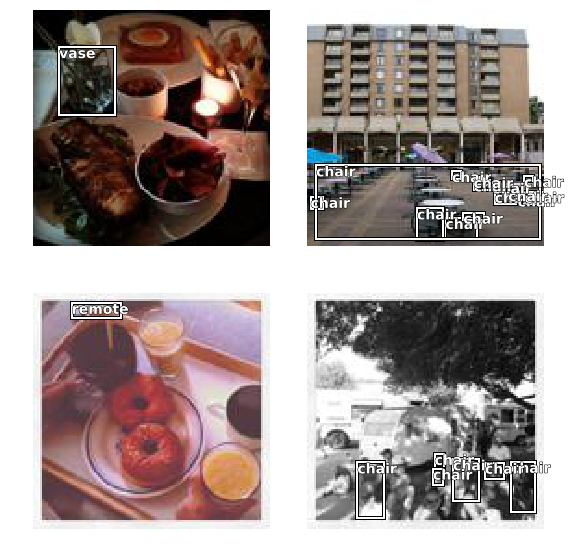

In [60]:
data = get_data()
data.show_batch(rows=2)

## RetinaNet

<b>TODO:</b>
1. pull pretrained resnet
- extract feature maps from pretrained resnet
- concat feature maps in cross-connections
- incorporate predictions at each level and push through 1by1 conv
- briefly train on camvid for pretrained test using categorical cross entropy
- figure out focal loss
- briefly train on camvid for class-imbalance test
- add classification subnet
- add regression subnet
- train on coco tiny
- train on coco
- see if you can match paper